# Time Series Analysis and Forecasting

In this task you will work with data from [this competition](https://www.kaggle.com/c/competitive-data-science-final-project) in a simplified version

This time-series dataset consists of daily sales data kindly provided by one of the largest Russian software firms - 1C Company. In the initial competition you are asked to predict total sales for every product and store in the next month. **In this HW you should predict total sales for the whole store network in the next day**

#### Tasks:
**1. (0.5 bonus points) Prepare data**
- download data and read it
- convert date to datetime using pd.to_datetime() with correct format
- group sales by dates

**2. (1.5 bonus points) Use SARIMA**
- fit the model (choose parameters wisely)
- visualize fitted curve and confidence intervals
- calculate MAPE

**3. (2 bonus points) Use two different ML model of your choice**

- you can use, for example, sktime, sklearn, Prophet or lightgbm, xgboost, catboost
- split data into train and test
- fit the model on a train data
- visualize fitted curve and confidence intervals for test data
- calculate MAPE

##### Write a couple of sentences about what you observe, what methods have better accuracy, less running time and so on 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings, itertools

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv('1C_sales.csv')

In [3]:
Y = sales[['date', 'item_cnt_day']]
Y['date'] = pd.to_datetime(Y['date'], format='%d.%m.%Y')
Y = Y.groupby(by='date').sum()
Y.columns = ['Sales']
Y.head()

,Sales
date,
2013-01-01,1951.0
2013-01-02,8198.0
2013-01-03,7422.0
2013-01-04,6617.0
2013-01-05,6346.0


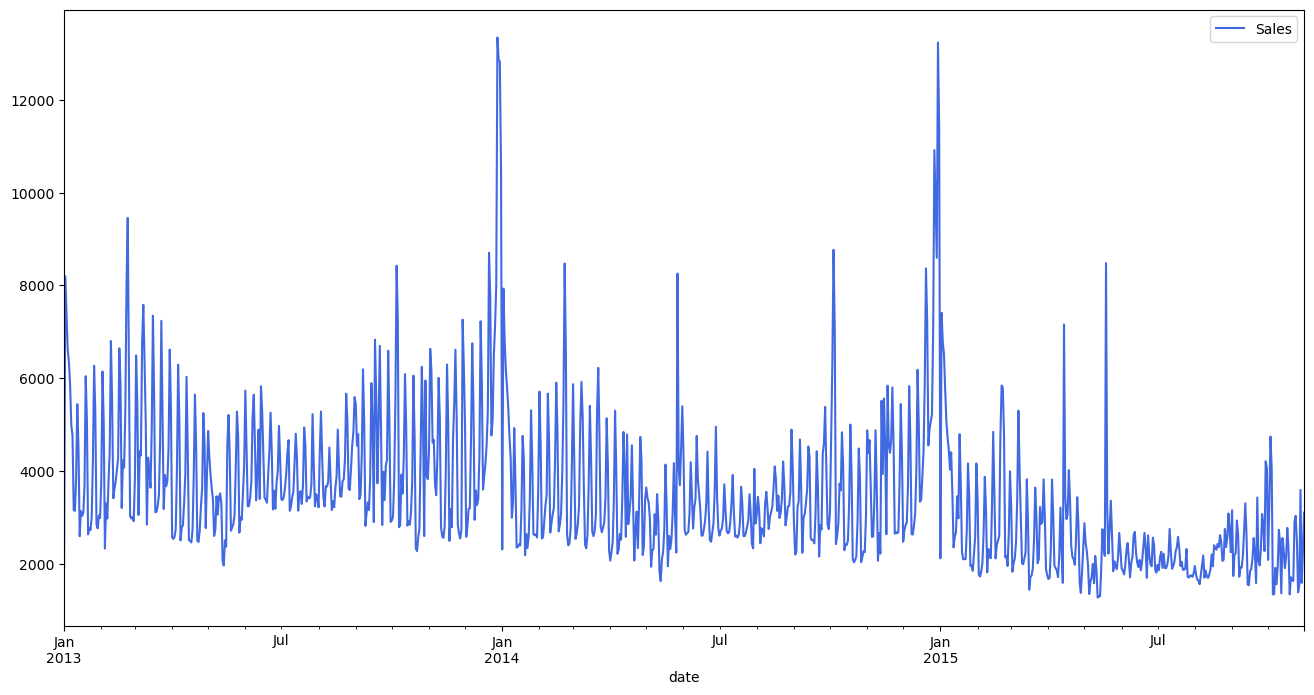

In [4]:
Y.plot(figsize=(16, 8), color='royalblue');

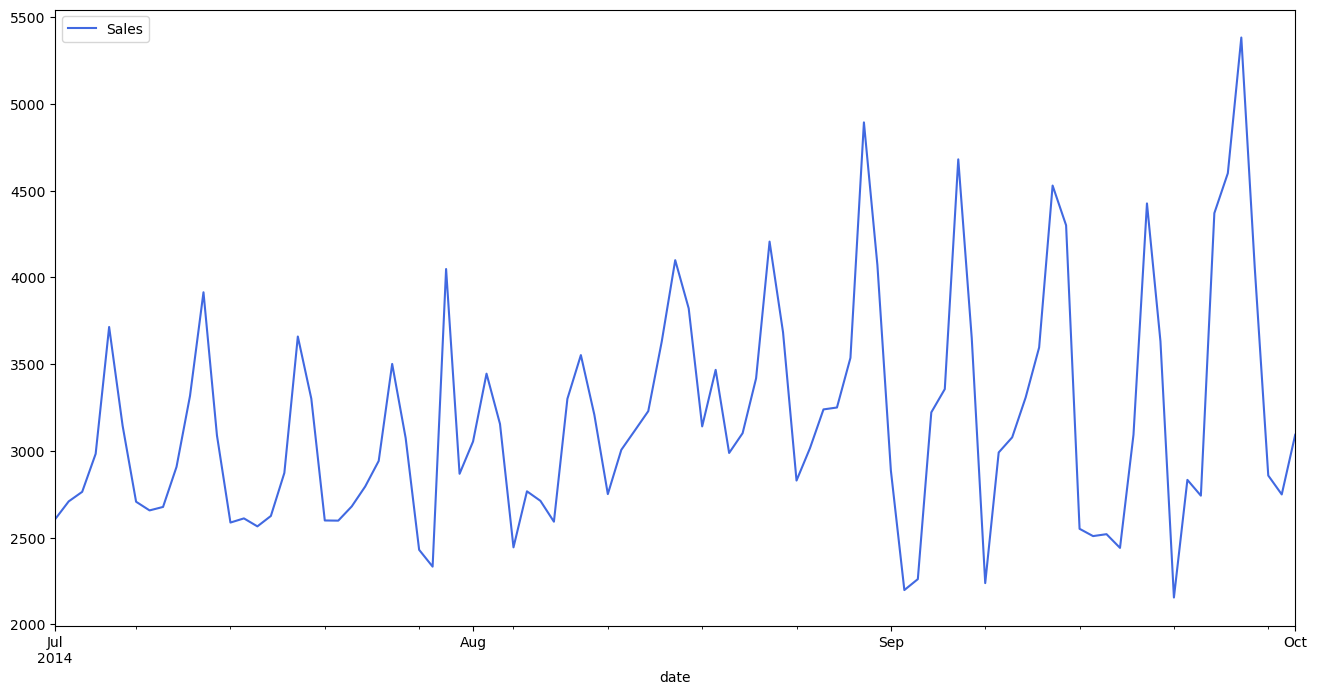

In [5]:
# look closer at the dynamics: consider 2014Q3, for example
Y[(Y.index >= '2014-07-01') & (Y.index <= '2014-10-01')].plot(figsize=(16,8), color='royalblue');

There is a slight downward trend and clearly weekly seasonality, let's inspect the presence of non-seasonal unit roots using ADF test. 

In [6]:
print(f'P-value: {adfuller(Y)[1].round(4)}')

P-value: 0.0012


P-value less than 1% but greater than 0.1%, so one may argue that we can reject the null of non-stationarity, but let keep this in mind and later compare models with d=0 and d=1. Let's look at ACF and PACF graphs for the original, first and seventh difference series in order to choose values of parameters p, q, P and Q.

In [7]:
Y_d1 = Y.diff().dropna()
Y_d7 = Y.diff(7).dropna()
Y_d1.columns = ['Sales diff(1)']
Y_d7.columns = ['Sales diff(7)']

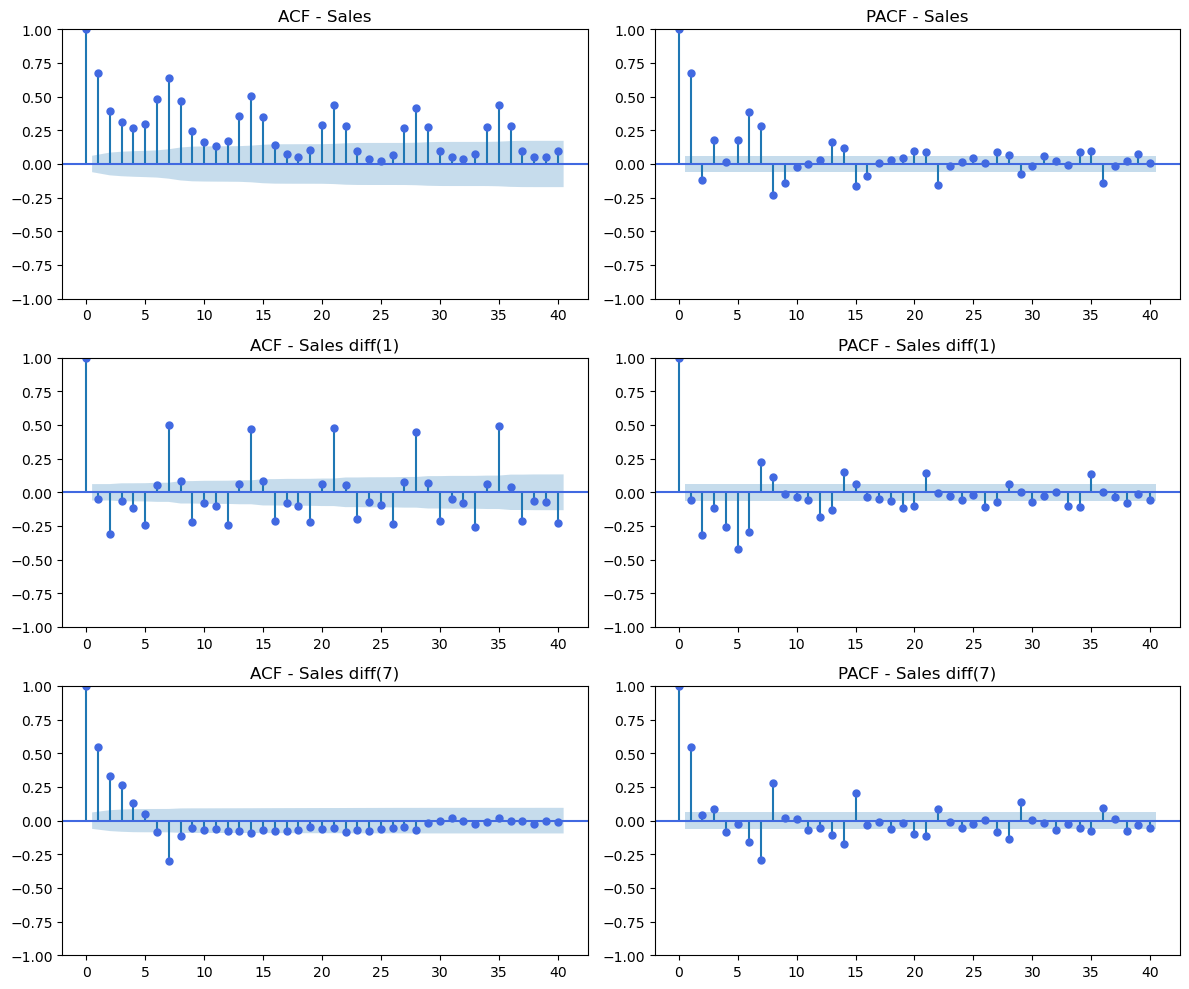

In [8]:
plt.figure(figsize=(12, 10)) 

for i, series in enumerate([Y, Y_d1, Y_d7], 1):
    plt.subplot(3, 2, 2*i-1)
    plot_acf(series, lags=40, ax=plt.gca(), color='royalblue')
    plt.title(f'ACF - {series.columns[0]}')

    plt.subplot(3, 2, 2*i)
    plot_pacf(series, lags=40, ax=plt.gca(), color='royalblue')
    plt.title(f'PACF - {series.columns[0]}')

plt.tight_layout()
plt.show()

There are literally no spikes under the X-axis of the sinusoidal ACF graph (hence, there are possibly no non-seasonal AR components, check max_p=2) with peaks in the vicinity of every 7th lag, which means that the seasonal AR order is presumably 1 (check maximum of 2 later for sure) with weekly frequency as the most significant spikes are concentrated in the vicinity of every 7th lag. <br>
Taking first seasonal differences leads to exponential decay of ACF till the $7 \times 1$ th lag, so my guess is that P = 1, for sure let's set it max to 2 in Grid Search (as was mentioned in previous abstract). PACF demonstrates single significant spikes at each 7th lag till the $7 \times 2$ th lag (next one is already almost insignificant), hence, it might be the case that q = 2 and Q = 1, but again will check max_q = 4 and max_Q = 3. <br>
Now I will choose the best SARIMA model using the built-in function `auto_arima` from `pmdarima` module.

In [9]:
pm.auto_arima(Y, start_p=1, max_p=2, d=1, start_q=0, max_q=4, 
                 start_P=1, max_P=4, D=1, start_Q=0, max_Q=3, m=7,
                 seasonal=True, stationary=False, trace=True);

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=17241.900, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=17557.456, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=16912.385, Time=0.70 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=17453.428, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=16911.762, Time=1.50 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=17196.499, Time=0.52 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=16913.504, Time=2.36 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.07 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=16911.856, Time=2.48 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=17090.402, Time=0.82 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=3.98 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=16953.7

In [ ]:
# DO NOT TRY TO RUN IT, TAKES TOO MUCH TIME SINCE NUMBER OF COMBINATIONS IS LARGE
sarimas = []
p_values = [1,2]
q_values = [1,2,3,4]
P_values = [1,2]
Q_values = [1,2,3]

for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    try:
        sarima = SARIMAX(Y, order=(p, 1, q), seasonal_order=(P, 1, Q, 7)).fit()
        sarimas.append(sarima)
    except np.linalg.LinAlgError:
        continue
        
min_index, min_aic = min(enumerate(sarimas), key=lambda x: x[1].aic)
min_index, min_aic

I do not know what causes this error, but I have tried to ignore it and obtained some outliers in results: 45 AICs were in normal range from 16812 to 16963, one was 18.0 and one - 12595. I thought it is strange and decided not to use this approach and focus on the SARIMA(0,1,1)(1,1,1)[7].

In [9]:
sarima = SARIMAX(Y, order=(0,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
print(sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1034
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8451.881
Date:                           Sun, 31 Dec 2023   AIC                          16911.762
Time:                                   09:39:50   BIC                          16931.496
Sample:                               01-01-2013   HQIC                         16919.253
                                    - 10-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4155      0.018    -22.832      0.000      -0.451      -0.380
ar.S.L7        0.0651      0.030      2.157

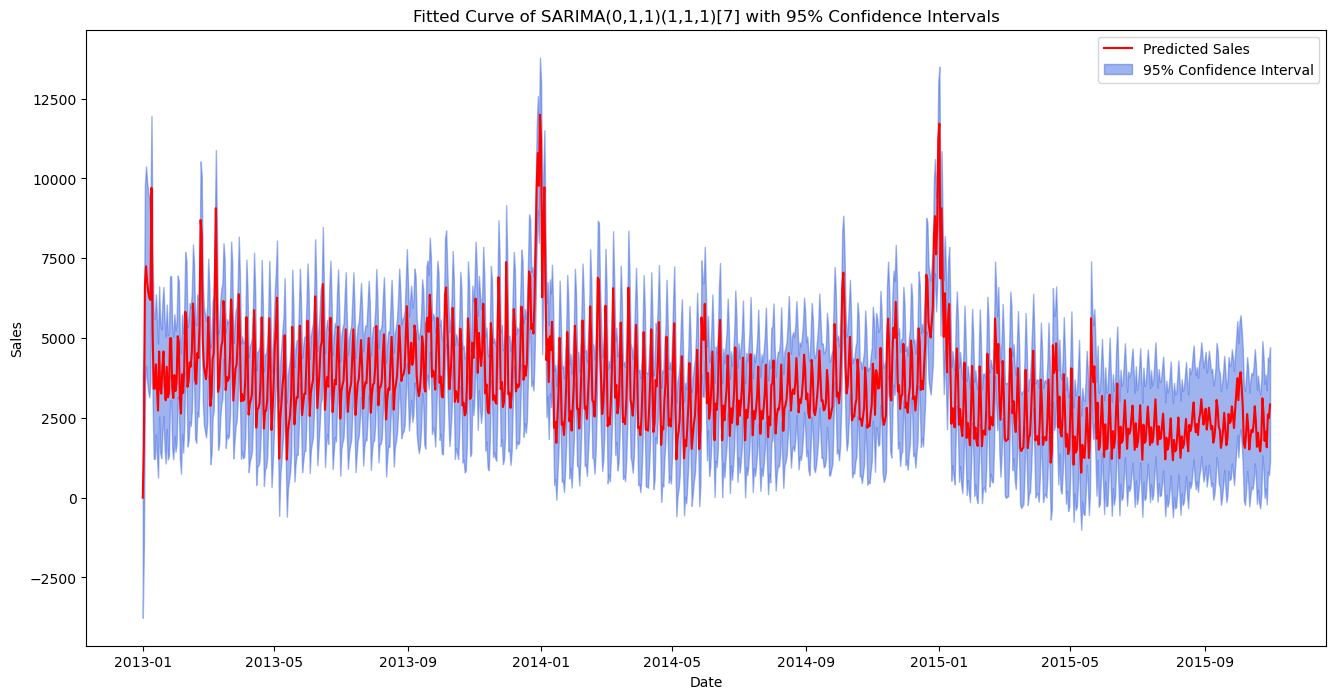

In [10]:
Y_hat_sarima = sarima.fittedvalues # in-sample forecast
ci_sarima = sarima.get_prediction().conf_int(alpha=0.05)
lb_sarima = ci_sarima['lower Sales'].to_numpy()
ub_sarima = ci_sarima['upper Sales'].to_numpy()

plt.figure(figsize=(16, 8))
plt.plot(Y_hat_sarima, label='Predicted Sales', color='red')
plt.fill_between(ci_sarima.index, lb_sarima, ub_sarima, color='royalblue', 
                 alpha=0.5, label='95% Confidence Interval')
plt.title('Fitted Curve of SARIMA(0,1,1)(1,1,1)[7] with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [11]:
def mape(true, pred):
    '''Calculates MAPE of Predicted Values'''
    Y = np.array(true).ravel()
    Y_hat = np.array(pred).ravel()
    
    return (abs((Y - Y_hat) / Y) * 100).mean()

In [12]:
mape_sarima = mape(Y, Y_hat_sarima)
print(f'SARIMA MAPE = {mape_sarima.round(3)}%')

SARIMA MAPE = 15.731%


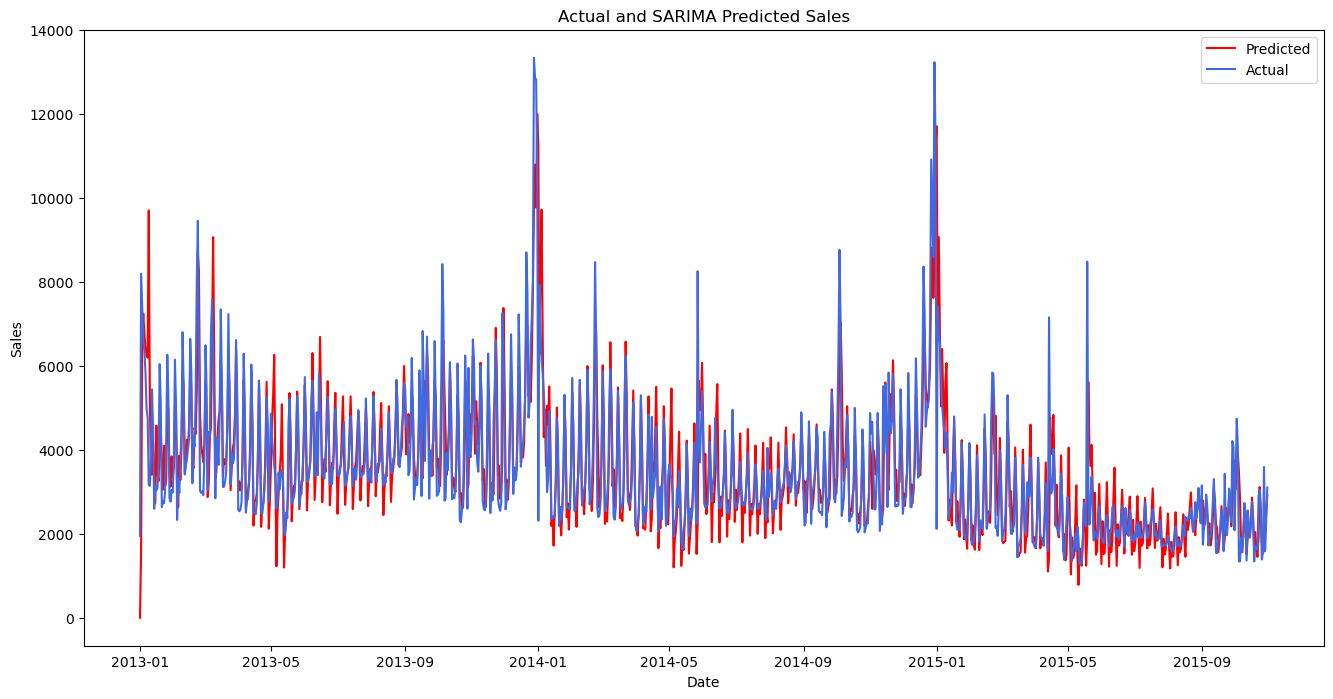

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(Y_hat_sarima, label='Predicted', color='red')
plt.plot(Y, label='Actual', color='royalblue')
plt.title('Actual and SARIMA Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

---

### XGBoost

To begin, generate a set of features by incorporating lagged values of the time series data. Given the weekly seasonality of the analyzed time series and the fact that on the previous stage we obtained P = Q = 1, it's essential to store all 7 lags as distinct variables (actually I've also tried adding as regressors just 7th, 14th and 21st lags, but it did not improve the forecast quality).

In [14]:
X = pd.DataFrame()
for i in range(1, 8): 
    X[f'Sales_L{i}'] = Y['Sales'].shift(i)
X.dropna(inplace=True)

In [15]:
X_train = X[X.index < '2015-06-01']
X_test = X[X.index >= '2015-06-01']

Split the whole sample into train and test, for example, from the February 2015 in order not to include the volatile January in the test.

In [17]:
Y_train = Y[Y.index < '2015-06-01'].iloc[7:,:] # 754 days
Y_test = Y[Y.index >= '2015-06-01'] # 273 days

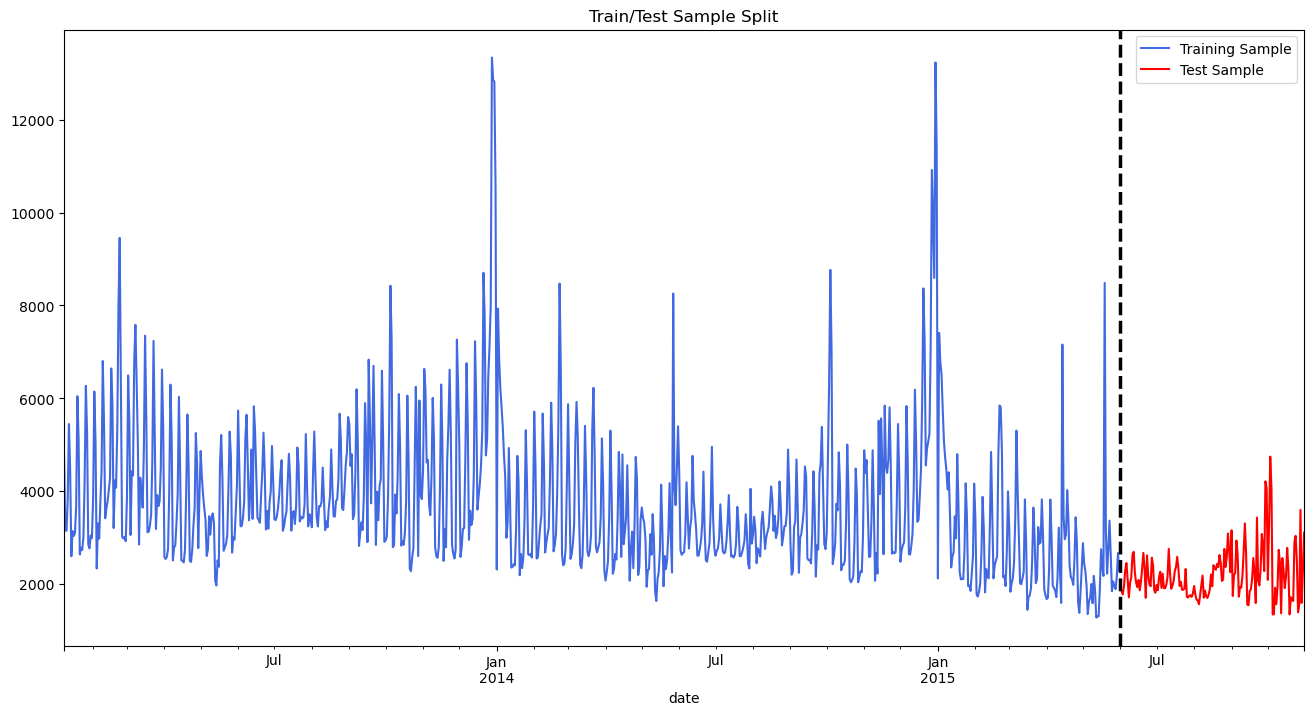

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
Y_train.plot(ax=ax, label='Training Sample', title='Train/Test Sample Split', color='royalblue')
Y_test.plot(ax=ax, label='Test Sample', color='red')
ax.axvline(pd.to_datetime('2015-06-01'), color='black', linestyle='--', linewidth=2.5)
ax.legend(['Training Sample', 'Test Sample'])
plt.show()

Ordinary Grid Search does not work correctly on time series data due to its dynamic structure, so it is necessary to use `TimeSeriesSplit()`. I've decided to choose `test_size` equal to 1.5 months so that the minimum train sample is 28 months.

In [19]:
param_grid = {'n_estimators': [10, 50, 100, 200, 400], 
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2], 
              'max_depth': [2, 3, 5, 7, 9]}

xgb = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=4, test_size=45)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X_train, Y_train);

In [20]:
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
Y_hat_xgb = best_xgb.predict(X_test)
mape_xgb = mape(Y_test, Y_hat_xgb)

for key, value in best_params.items():
        print(f'Best {key}: {value}')
print(f'XGBoost MAPE = {mape_xgb.round(3)}%')

Best learning_rate: 0.05
Best max_depth: 5
Best n_estimators: 200
XGBoost MAPE = 24.794%


I've written the function which calculates predictive intervals recursively depending on the whole train sample and all past predicted test sample values: $$PI_{0.05;\,t} = \hat{Y}_t \pm 1.96 \, \times \, \hat{\sigma}(\{Y_1,Y_2,\dots,Y_{t_{train}},\hat{Y}_1,\dots,\hat{Y}_{t-1}\})$$

In [21]:
def pi(train, pred):
    '''Calculates Predicted Intervals Bases on True Train and Predicted Test Samples'''
    
    Y = np.array(train).ravel()
    Y_hat = np.array(pred).ravel()
    
    lbs = []
    ubs = []
    
    for t in range(len(Y_hat)):
        past_sample = np.append(Y, Y_hat[:t])
        lb = Y_hat[t] - 1.96 * np.std(past_sample)
        ub = Y_hat[t] + 1.96 * np.std(past_sample)
        lbs.append(lb)
        ubs.append(ub)
        
    pi_df = pd.DataFrame({'lower': lbs, 'upper': ubs})
    
    return pi_df

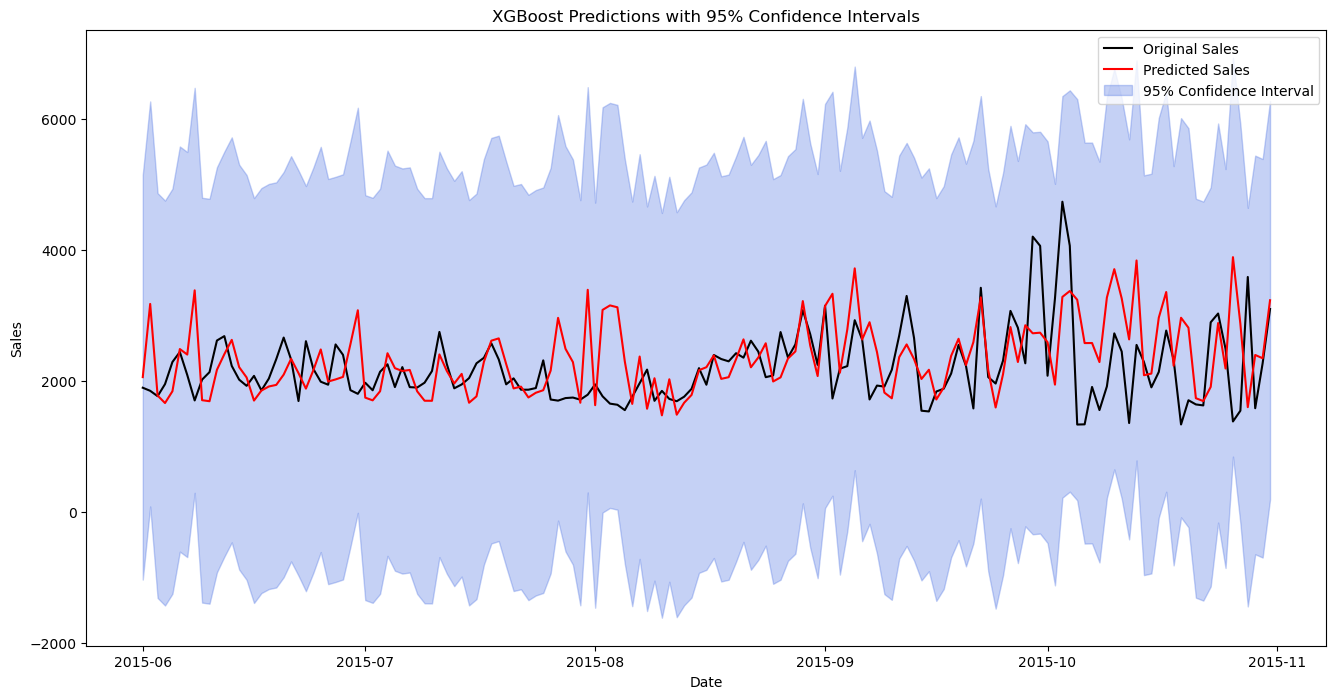

In [22]:
pi_xgb = pi(Y_train, Y_hat_xgb)

plt.figure(figsize=(16, 8))
plt.plot(Y_test.index, Y_test, label='Original Sales', color='black')
plt.plot(Y_test.index, Y_hat_xgb, label='Predicted Sales', color='red')
plt.fill_between(Y_test.index, np.array(pi_xgb['lower']), np.array(pi_xgb['upper']), color='royalblue', 
                 alpha=0.3, label='95% Confidence Interval')
plt.title('XGBoost Predictions with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

---

### Error, Trend and Seasonality (ETS) model. Also called Exponential Smoothing
ETS models do not imply neither cross-validation nor explanatory variables, thus I've decided to expand the training sample by one more month. <br>
Since it was found that there is practically no trend in the data, and weekly seasonality takes place, the ETS(A,N,M) or ETS(A,N,A) should be estimated. To choose the best model, do the Grid Search among all possible parameters.

In [23]:
Y_train1 = Y[Y.index < '2015-07-01'] # 973 days
Y_test1 = Y[Y.index >= '2015-07-01'] # 61 days

trends = ['add', 'mul', None]
seasonals = ['add', 'mul', None]
ets_grid_search = []

for trend, seasonal in itertools.product(trends, seasonals):
    ets = ExponentialSmoothing(trend=trend, seasonal=seasonal, sp=7).fit(Y_train1)  # sp=7 для недельной сезонности
    Y_hat_ets = ets.predict(fh=range(1, len(Y_test1) + 1))
    mape_ets = mape(Y_test1, Y_hat_ets)
    ets_grid_search.append((ets, mape_ets))

ets_grid_search = sorted(ets_grid_search, key=lambda x: x[1])
ets_grid_search

[(ExponentialSmoothing(seasonal='mul', sp=7), 15.504067242212374),
 (ExponentialSmoothing(sp=7), 18.61011492088646),
 (ExponentialSmoothing(seasonal='add', sp=7), 21.543324704079744),
 (ExponentialSmoothing(seasonal='mul', sp=7, trend='add'), 27.645626460520297),
 (ExponentialSmoothing(seasonal='add', sp=7, trend='add'), 35.42011328637146),
 (ExponentialSmoothing(sp=7, trend='add'), 46.60552500652006),
 (ExponentialSmoothing(seasonal='add', sp=7, trend='mul'), 47.78989117555035),
 (ExponentialSmoothing(sp=7, trend='mul'), 78.85962100171325),
 (ExponentialSmoothing(seasonal='mul', sp=7, trend='mul'), 81.55107770156157)]

**ETS(A,N,M)** turned out to be the best model with **MAPE = 15.504%**. It is even smaller than for SARIMA!

In [24]:
ets = ets_grid_search[0][0]
Y_hat_ets = ets.predict(fh=range(1, len(Y_test1) + 1))
mape_ets = mape(Y_test1, Y_hat_ets)

In [25]:
pi_ets = pi(Y_test1, Y_hat_ets)

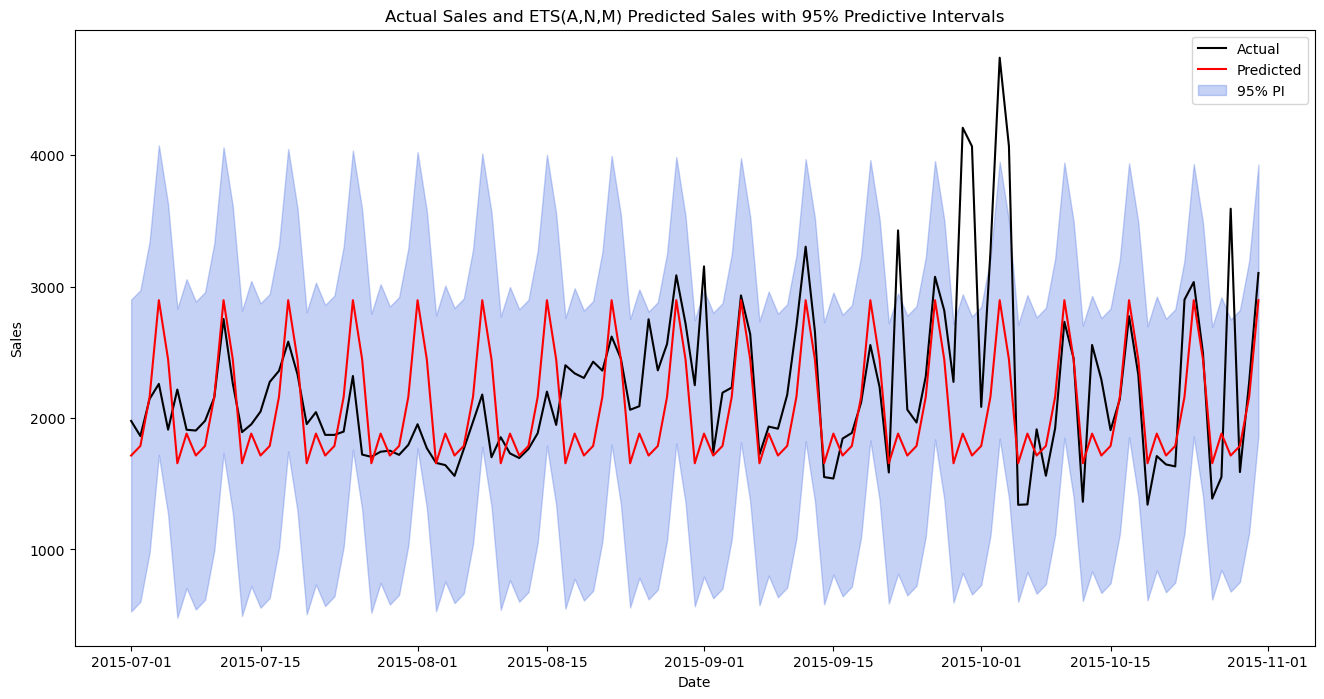

In [26]:
plt.figure(figsize=(16, 8))
plt.plot(Y_test1, label='Actual', color='black')
plt.plot(Y_hat_ets, label='Predicted', color='red')
plt.fill_between(Y_hat_ets.index, np.array(pi_ets['lower']), np.array(pi_ets['upper']), color='royalblue', 
                 alpha=0.3, label='95% PI')
plt.title('Actual Sales and ETS(A,N,M) Predicted Sales with 95% Predictive Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

---

## Summary

In [27]:
summary = pd.DataFrame({'SARIMA(0,1,1)(1,1,1)[7]': f'{mape_sarima.round(3)}%',
                        'XGBoost': f'{mape_xgb.round(3)}%',
                        'ETS(A,N,M)': f'{mape_ets.round(3)}%'}, index=['MAPE'])
summary

,"SARIMA(0,1,1)(1,1,1)[7]",XGBoost,"ETS(A,N,M)"
MAPE,15.731%,24.794%,15.504%


The ETS(A,N,M) model ranks first in terms of forecast quality $\Longrightarrow$ predict total sales for the whole store network in the next 7 days, i.e. first week of November 2015:

In [28]:
ets.predict(fh=range(1, len(Y_test1) + 8))[-7:]

,Sales
2015-11-01,2446.504535
2015-11-02,1655.882809
2015-11-03,1881.778792
2015-11-04,1714.918666
2015-11-05,1787.745210
2015-11-06,2161.552160
2015-11-07,2896.901303
